In [2]:
import sys
sys.path.append('/data/virtual_envs/sdc-c1-gpu-augment/lib/python3.7/site-packages')

In [3]:
import glob
import json
import os

import albumentations as A

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import numpy as np

from PIL import Image

# Albumentations

Albumentations is a python library for image augmentation. Almost every time you train a convolutional neural network, you need to use image augmentation to reduce overfitting and increase the variability in your dataset.

## Simple augmentations

Let's visualize the original image. Albumentations expects numpy array so we will convert the Pillow image to a numpy array.

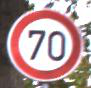

In [4]:
img = Image.open('data/00012_00027.jpg').convert('RGB')
img

In [5]:
img = np.array(img)
img

array([[[ 45,  40,  37],
        [ 48,  43,  40],
        [ 51,  46,  43],
        ..., 
        [244, 239, 236],
        [211, 207, 204],
        [200, 199, 195]],

       [[ 45,  40,  37],
        [ 49,  44,  41],
        [ 53,  48,  45],
        ..., 
        [190, 185, 182],
        [157, 153, 150],
        [161, 160, 156]],

       [[ 46,  41,  38],
        [ 50,  45,  42],
        [ 55,  50,  47],
        ..., 
        [118, 112, 112],
        [117, 113, 112],
        [153, 152, 150]],

       ..., 
       [[ 75,  65,  63],
        [ 78,  68,  66],
        [ 76,  66,  64],
        ..., 
        [249, 240, 235],
        [231, 221, 220],
        [208, 199, 200]],

       [[ 75,  65,  63],
        [ 77,  67,  65],
        [ 76,  66,  64],
        ..., 
        [182, 170, 158],
        [167, 154, 146],
        [146, 135, 129]],

       [[ 75,  65,  63],
        [ 77,  67,  65],
        [ 76,  66,  64],
        ..., 
        [131, 119,  97],
        [126, 113,  96],
        [120, 107,

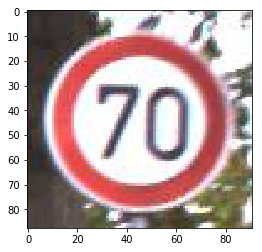

In [6]:
plt.imshow(img)
plt.show()

Let's experiment with rotation. To create a rotation augmentation, you need to use the `A.Rotate` function. In the parameters, you can set the `limit` which is the rotation angle in degrees. 

Albumentations augmentations always have the following parameters:
* **p [float]**: probability to apply this augmentations
* **always_apply [bool]**: always apply this augmentation or not

In [7]:
augmentation = A.Rotate(limit=90, always_apply=True)
augmentation

Rotate(always_apply=True, p=0.5, limit=(-90, 90), interpolation=1, border_mode=4, value=None, mask_value=None)

We apply the augmentation by running:

In [8]:
augmented = augmentation(image=img)
augmented

{'image': array([[[ 53,  48,  45],
         [ 56,  51,  48],
         [ 59,  54,  51],
         ..., 
         [247, 245, 248],
         [254, 252, 255],
         [255, 254, 255]],
 
        [[ 53,  48,  45],
         [ 55,  50,  47],
         [ 57,  52,  49],
         ..., 
         [255, 254, 255],
         [254, 253, 254],
         [250, 248, 249]],
 
        [[ 55,  50,  47],
         [ 56,  51,  48],
         [ 56,  51,  48],
         ..., 
         [255, 255, 255],
         [255, 254, 255],
         [252, 250, 251]],
 
        ..., 
        [[ 77,  67,  65],
         [ 77,  67,  65],
         [ 79,  69,  67],
         ..., 
         [205, 199, 184],
         [162, 154, 129],
         [123, 114,  82]],
 
        [[ 77,  67,  65],
         [ 75,  65,  63],
         [ 78,  68,  66],
         ..., 
         [191, 192, 179],
         [137, 139, 118],
         [114, 114,  86]],
 
        [[ 77,  67,  65],
         [ 74,  64,  62],
         [ 79,  69,  67],
         ..., 
         [171,

And we can get the augmented image:

In [9]:
augmented_img = augmented['image']

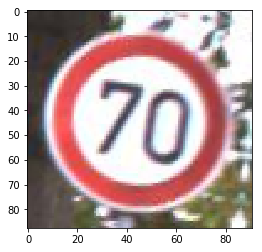

In [10]:
plt.imshow(augmented_img)
plt.show()

## Compose augmentations

We can use `Compose` to combine multiple augmentations. `Compose` takes a list of augmentations.

In [11]:
augmentations = A.Compose([
    A.Rotate(limit=90, p=1.0),
    A.RandomContrast(p=1.0),
    A.CoarseDropout(p=1.0)
])
augmentations

Compose([
  Rotate(always_apply=False, p=1.0, limit=(-90, 90), interpolation=1, border_mode=4, value=None, mask_value=None),
  RandomContrast(always_apply=False, p=1.0, limit=(-0.2, 0.2)),
  CoarseDropout(always_apply=False, p=1.0, max_holes=8, max_height=8, max_width=8, min_holes=8, min_height=8, min_width=8),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})

In [12]:
augmented = augmentations(image=img)
augmented_img = augmented['image']

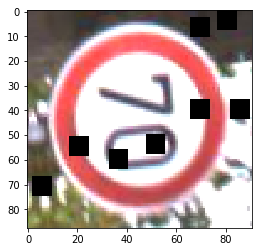

In [13]:
plt.imshow(augmented_img)
plt.show()

## Augmentations with bounding boxes

Finally, we can also apply augmentations to image with bounding boxes.

Let's load an image

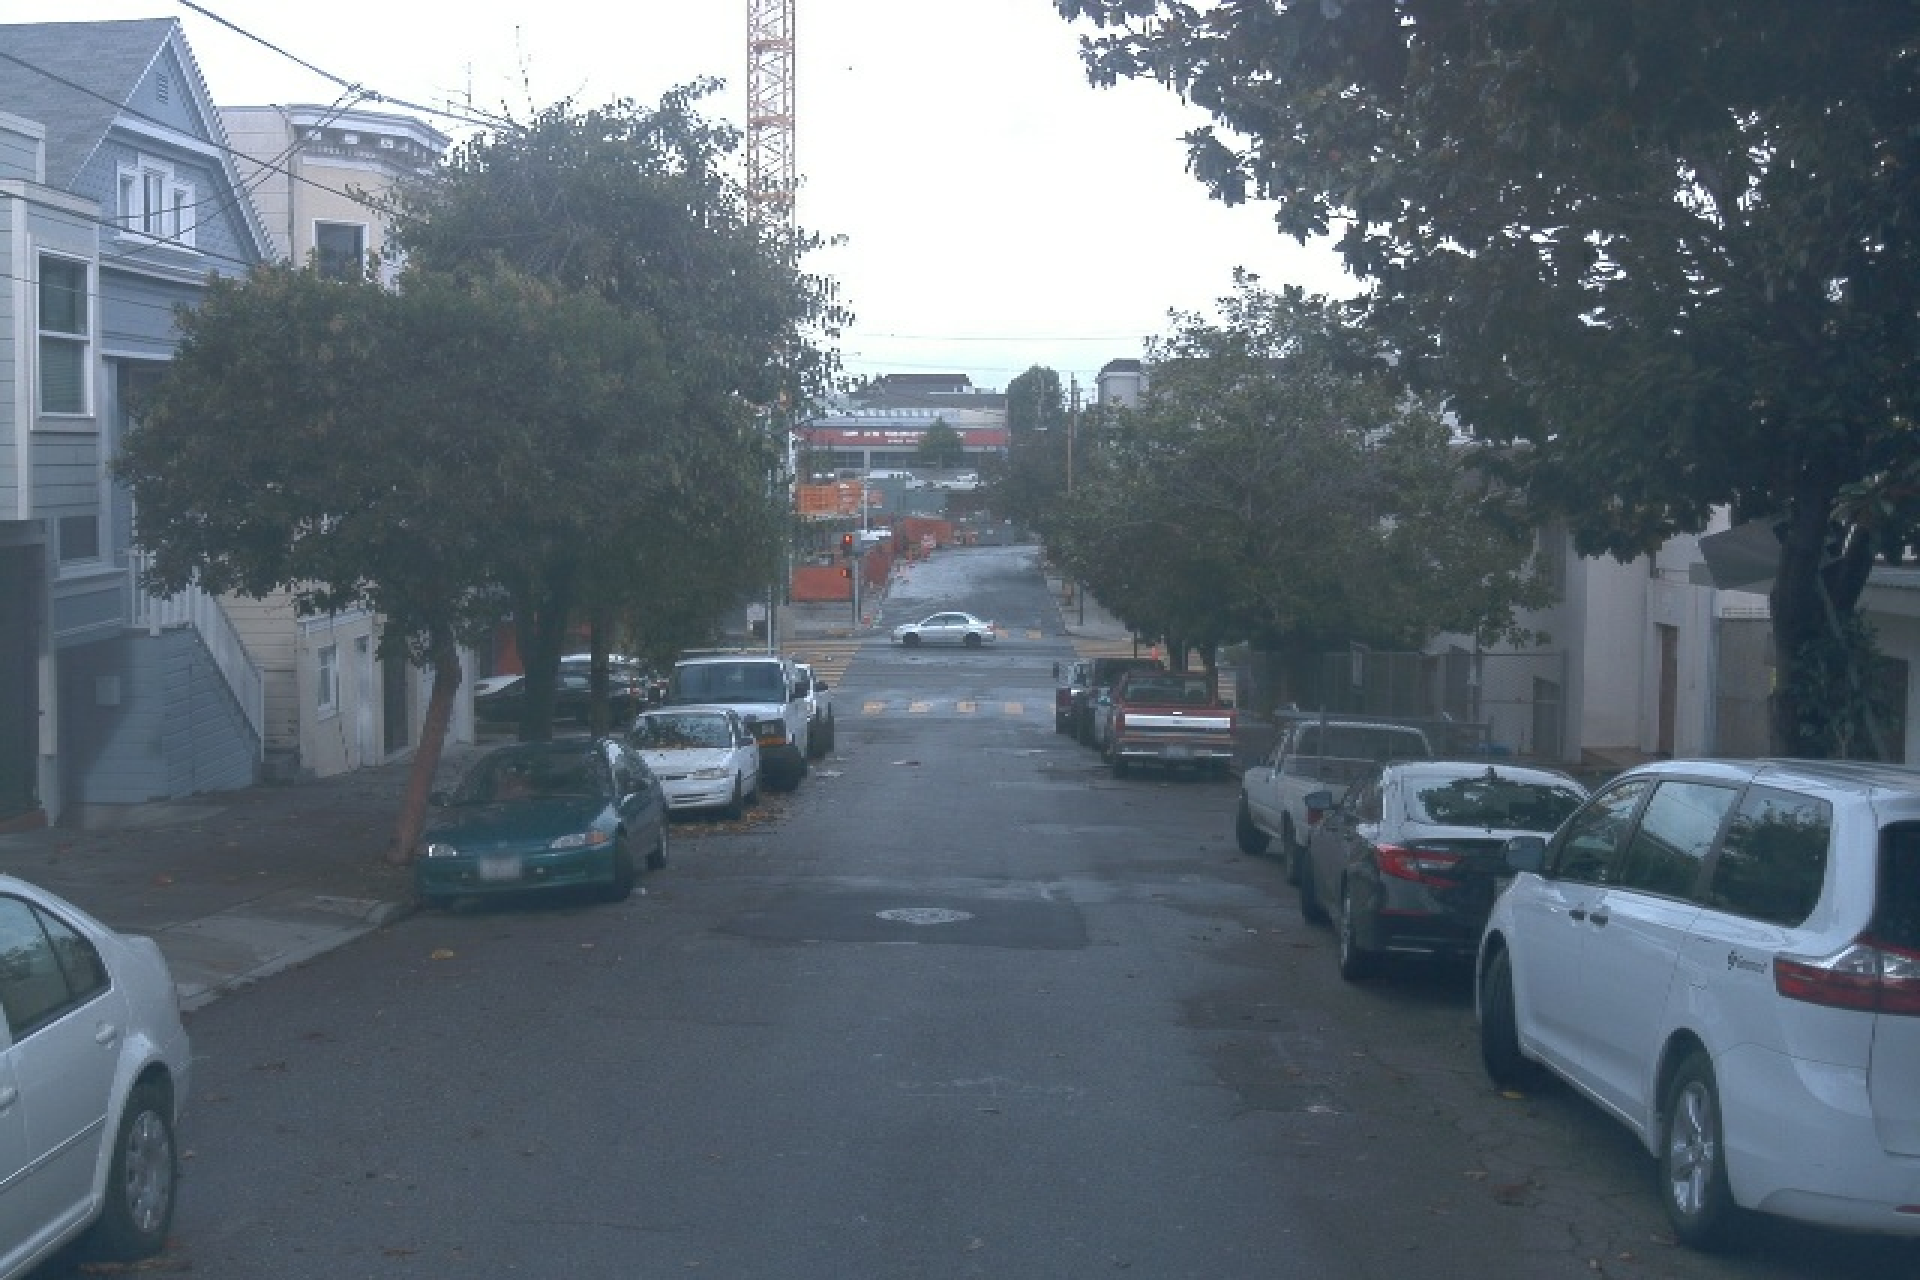

In [14]:
img = Image.open('data/segment-12208410199966712301_4480_000_4500_000_with_camera_labels_83.png').convert('RGB')
img

In [15]:
img = np.array(img)
img.shape

(1280, 1920, 3)

And the corresponding annotations

In [16]:
with open('data/ground_truth.json') as f:
    annotations = json.load(f)
    
annotations

{'boxes': [[0, 868, 198, 1280],
  [1231, 698, 1500, 886],
  [1089, 670, 1234, 782],
  [1088, 677, 1118, 750],
  [868, 465, 928, 490],
  [471, 646, 673, 706],
  [470, 671, 652, 730],
  [410, 737, 667, 916],
  [795, 661, 834, 762],
  [645, 644, 810, 793],
  [887, 610, 993, 649],
  [1044, 660, 1091, 738],
  [1068, 653, 1167, 745],
  [929, 474, 994, 495],
  [1295, 751, 1594, 983],
  [1466, 752, 1920, 1262],
  [620, 705, 761, 822]],
 'classes': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'filename': 'segment-12208410199966712301_4480_000_4500_000_with_camera_labels_83.png'}

We can display the original image with the annotations

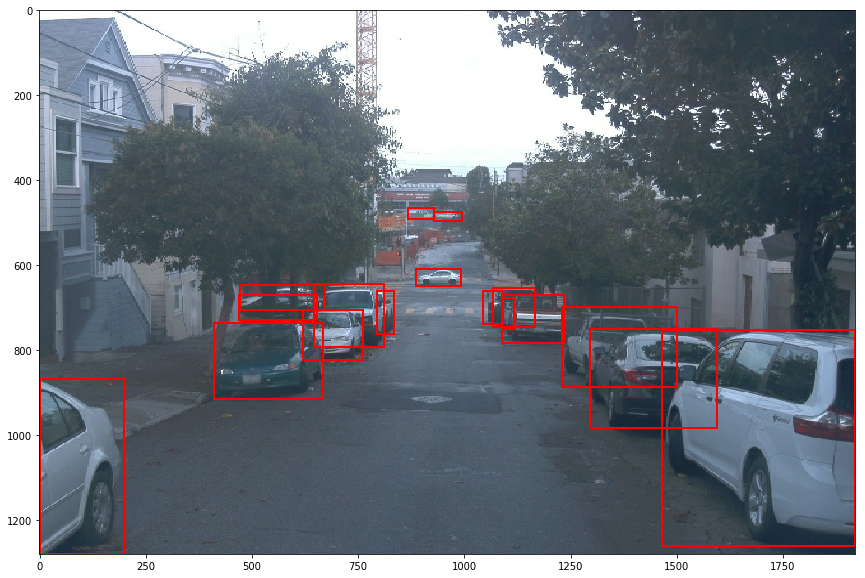

In [17]:
f, ax = plt.subplots(1, figsize=(15, 10))
ax.imshow(img)
for bb in annotations['boxes']:
    y1, x1, y2, x2 = bb
    rec = Rectangle((y1, x1), y2-y1, x2-x1, facecolor='none', edgecolor='r', linewidth=2)
    ax.add_patch(rec)
plt.show()

Let's define a list of augmentations. We are going to flip the image horizontally, randomly crop it and apply couple pixel level transformations

In [18]:
augmentation_lst = [
    A.RandomResizedCrop(height=1024, width=1024, p=1.0),
    A.HorizontalFlip(p=1.0),
    A.RandomContrast(p=1.0),
    A.CoarseDropout(max_height=30, max_width=30, p=1.0)
]
augmentation_lst

[RandomResizedCrop(always_apply=False, p=1.0, height=1024, width=1024, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=1),
 HorizontalFlip(always_apply=False, p=1.0),
 RandomContrast(always_apply=False, p=1.0, limit=(-0.2, 0.2)),
 CoarseDropout(always_apply=False, p=1.0, max_holes=8, max_height=30, max_width=30, min_holes=8, min_height=30, min_width=30)]

When creating the composition, we need to add an extra argument. 

`bbox_params` will describe the following:
* the bounding boxes format. In our case, we use the x1, y1, x2, y2 format, which corresponds to the Pascal VOC dataset.
* the `min_area` argument controls the minimum area of the augmented bounding boxes. After cropping or resizing, if a bounding box area is under this threshold, it will be deleted.
* the `label_fields` argument just set the name of the classes id field in our input dictionnary

In [23]:
augmentations = A.Compose(
    augmentation_lst,
    bbox_params=A.BboxParams(
        format='pascal_voc',
        min_area=100,
        label_fields=['classes']
    )
)
augmentations

Compose([
  RandomResizedCrop(always_apply=False, p=1.0, height=1024, width=1024, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=1),
  HorizontalFlip(always_apply=False, p=1.0),
  RandomContrast(always_apply=False, p=1.0, limit=(-0.2, 0.2)),
  CoarseDropout(always_apply=False, p=1.0, max_holes=8, max_height=30, max_width=30, min_holes=8, min_height=30, min_width=30),
], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['classes'], 'min_area': 100, 'min_visibility': 0.0}, keypoint_params=None, additional_targets={})

Let's create the input dictionnary

In [24]:
input_data = {
    'image': img,
    'bboxes': annotations['boxes'],
    'classes': annotations['classes']
}

In [25]:
augmented = augmentations(**input_data)

Finally we can display the augmented image with the corresponding bounding boxes

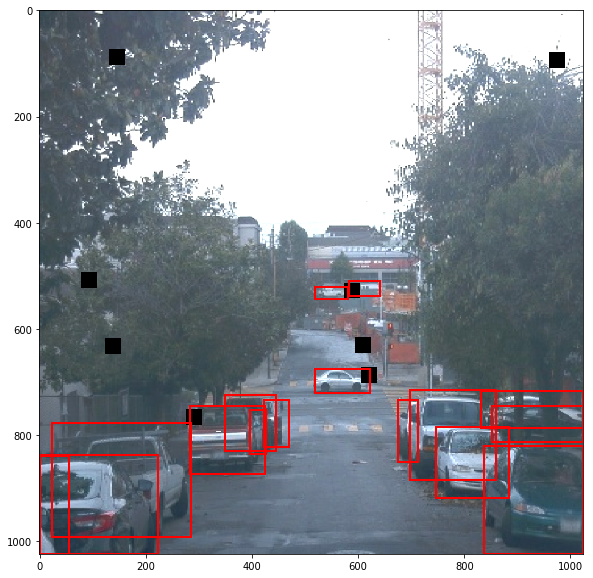

In [26]:
f, ax = plt.subplots(1, figsize=(15,10))
ax.imshow(augmented['image'])
for bb in augmented['bboxes']:
    y1, x1, y2, x2 = bb
    rec = Rectangle((y1, x1), y2-y1, x2-x1, facecolor='none', edgecolor='r', linewidth=2)
    ax.add_patch(rec)
plt.show()